<a href="https://colab.research.google.com/github/ShahedSabab/Customer-loan-enquiry/blob/master/Customer_Loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from collections import Counter
import pickle
from sklearn.externals import joblib
import warnings
from pylab import rcParams
from matplotlib import rc
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 20
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Define Model and plot methods 

In [0]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(400, activation = 'relu', kernel_initializer = 'random_normal', input_dim = X_train.shape[1]),
        tf.keras.layers.Dropout(rate = dropout_prob),
        tf.keras.layers.Dense(400, activation = 'relu', kernel_initializer = 'random_normal', kernel_regularizer=regularizers.l1(regulizer)),
        tf.keras.layers.Dropout(rate = dropout_prob),
        tf.keras.layers.Dense(200, activation = 'relu', kernel_initializer = 'random_normal'),
        tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal')
        ])
    print(model.summary())
    return model

def plot_graphs(f, history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Initialize variables

In [0]:
#initialize variables 
num_epoch = 100
batch_size = 20
learning_rate = 0.01
regulizer = 0.01
verbose = 2
validation_split = 0.2
dropout_prob = 0.5
test_size = 0.2
rcParams['figure.figsize'] = 12,8

# Read Data 

In [0]:
!gdown --id 1_lOntWqoxT0vwWkCq8g0BehilnpAQGKH --output bankloan.csv

Downloading...
From: https://drive.google.com/uc?id=1_lOntWqoxT0vwWkCq8g0BehilnpAQGKH
To: /content/bankloan.csv
100% 38.0k/38.0k [00:00<00:00, 68.0MB/s]


In [0]:
df = pd.read_csv("bankloan.csv")

# Drop missing values

In [0]:
df = df.dropna()

# Drop unnecessary features

In [0]:
df = df.drop('Loan_ID', axis = 1)

# Check data distribution

[Text(0, 0, 'N'), Text(0, 0, 'Y')]

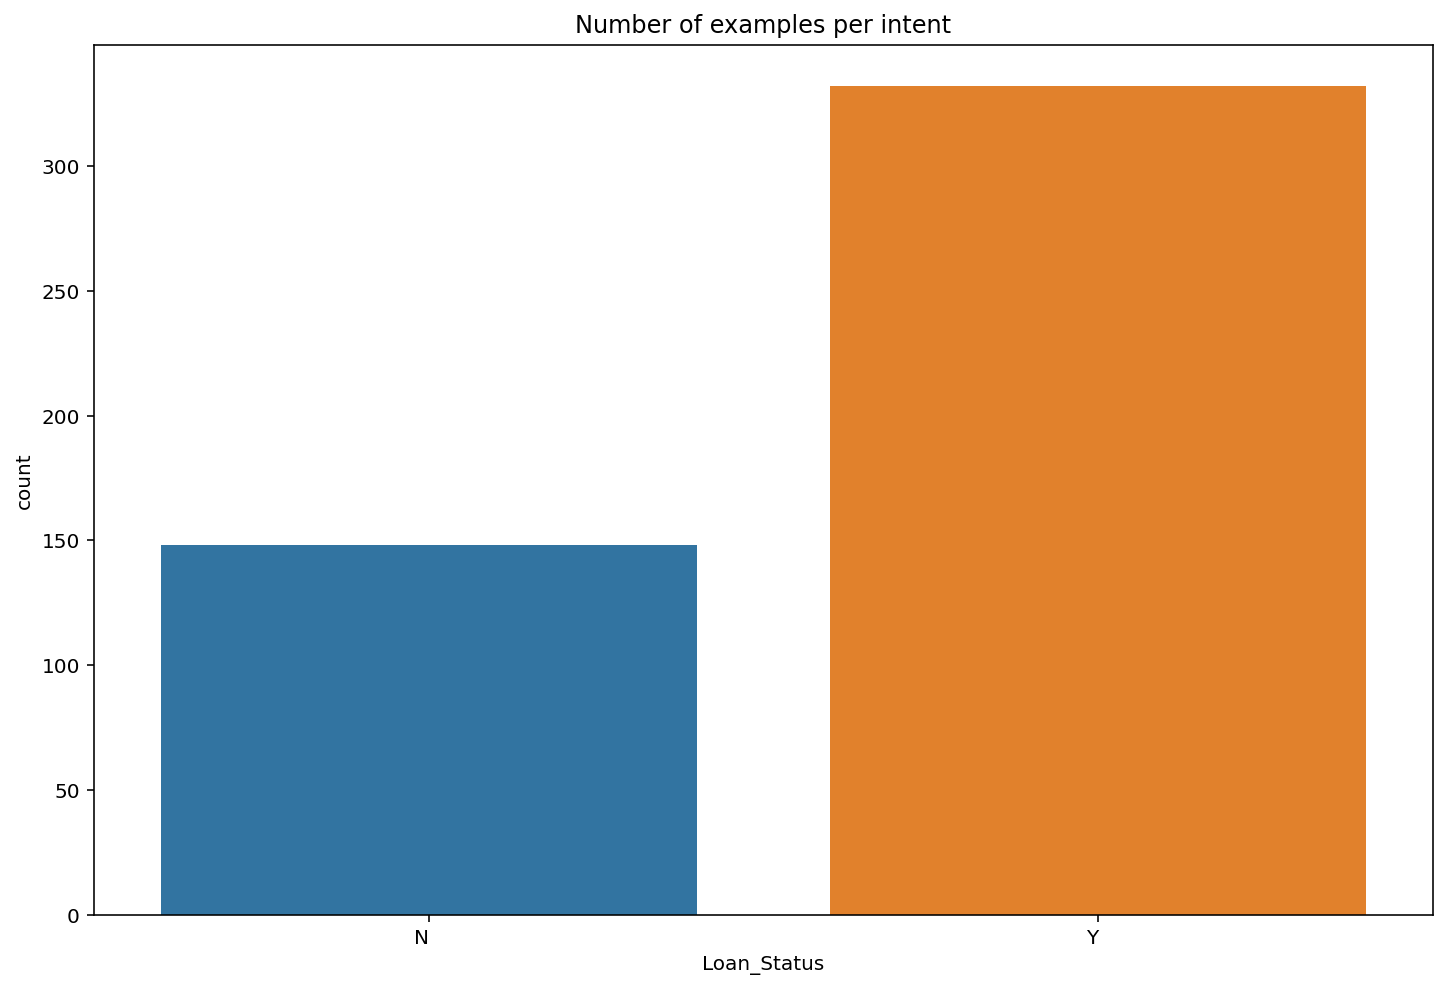

In [0]:
chart = sns.countplot(df.Loan_Status)
plt.title("Number of examples per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0, horizontalalignment= 'right')

# Convert categorical features

In [0]:
pr_dfy = df['Loan_Status']
pr_dfx = df.drop('Loan_Status', axis = 1)
d_x  = pd.get_dummies(pr_dfx)
d_y = pr_dfy.map(dict(Y=1, N=0))

# Oversampling minority class

In [0]:
sm = SMOTE()
X1, y = sm.fit_sample(d_x, d_y)

# Check distribution after sampling

[Text(0, 0, '0'), Text(0, 0, '1')]

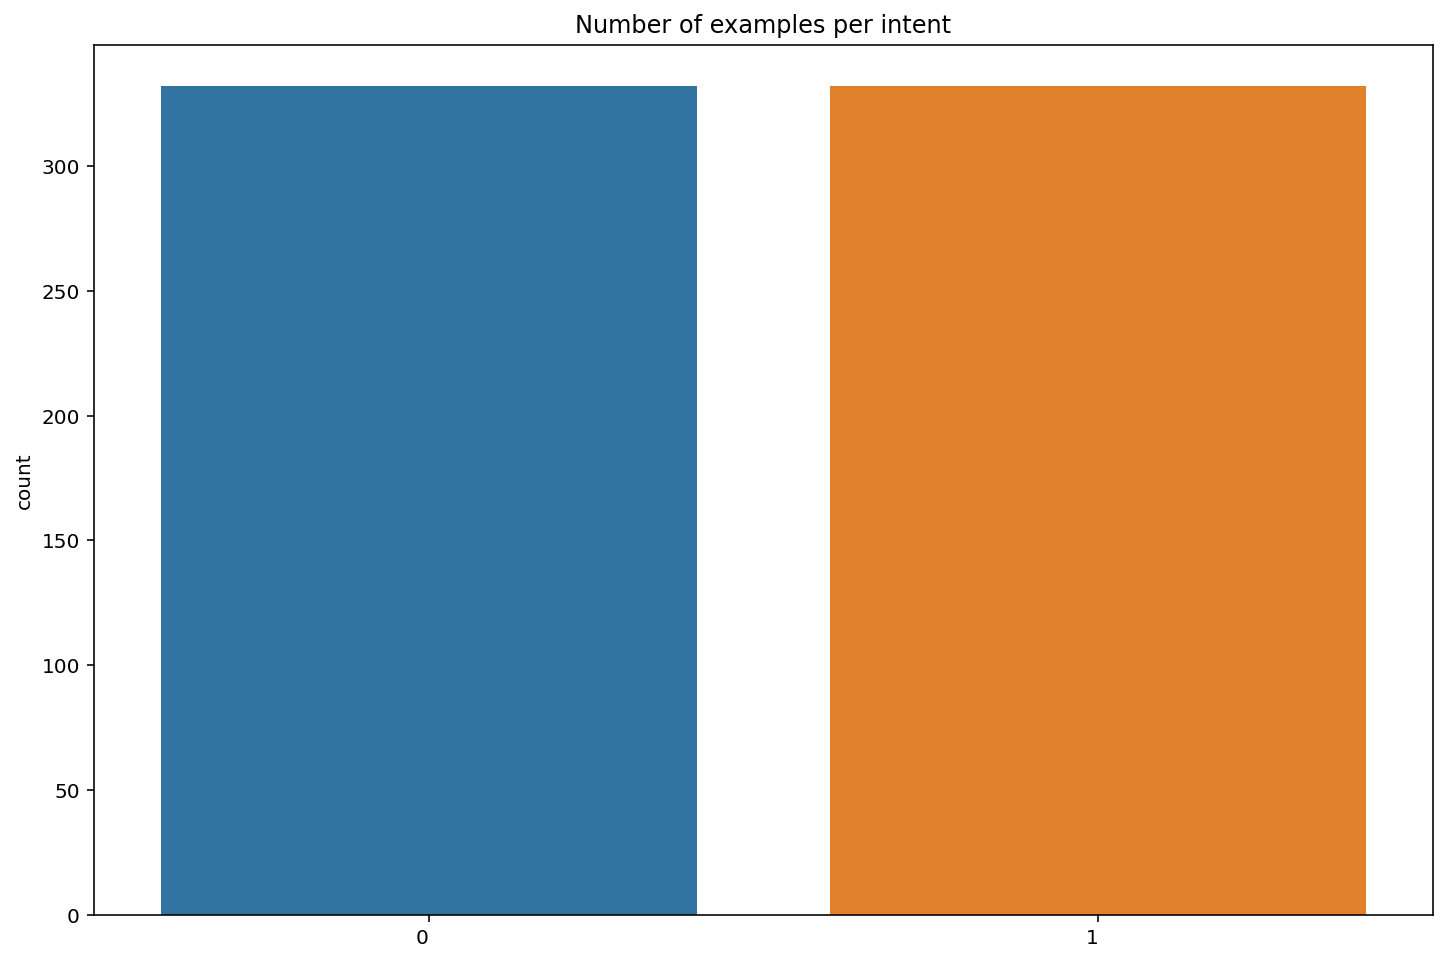

In [0]:
chart = sns.countplot(y)
plt.title("Number of examples per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0, horizontalalignment= 'right')

# Normalize the data

In [0]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X1)

fileName = 'scaler.pkl'
joblib.dump(scaler, fileName)

['scaler.pkl']

# Train-test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=RANDOM_SEED, shuffle = True, stratify=y)

# Define model

In [0]:
model = create_model()
opt = tf.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer = opt, metrics = ['accuracy'])


history = model.fit(X_train, 
                    y_train, 
                    epochs = num_epoch,
                    validation_split=validation_split,
                    batch_size = batch_size,
                    verbose=verbose)

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_277 (Dense)            (None, 400)               7200      
_________________________________________________________________
dropout_76 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_278 (Dense)            (None, 400)               160400    
_________________________________________________________________
dropout_77 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_279 (Dense)            (None, 200)               80200     
_________________________________________________________________
dense_280 (Dense)            (None, 1)                 201       
Total params: 248,001
Trainable params: 248,001
Non-trainable params: 0
_______________________________________________

# Plot loss accuracy

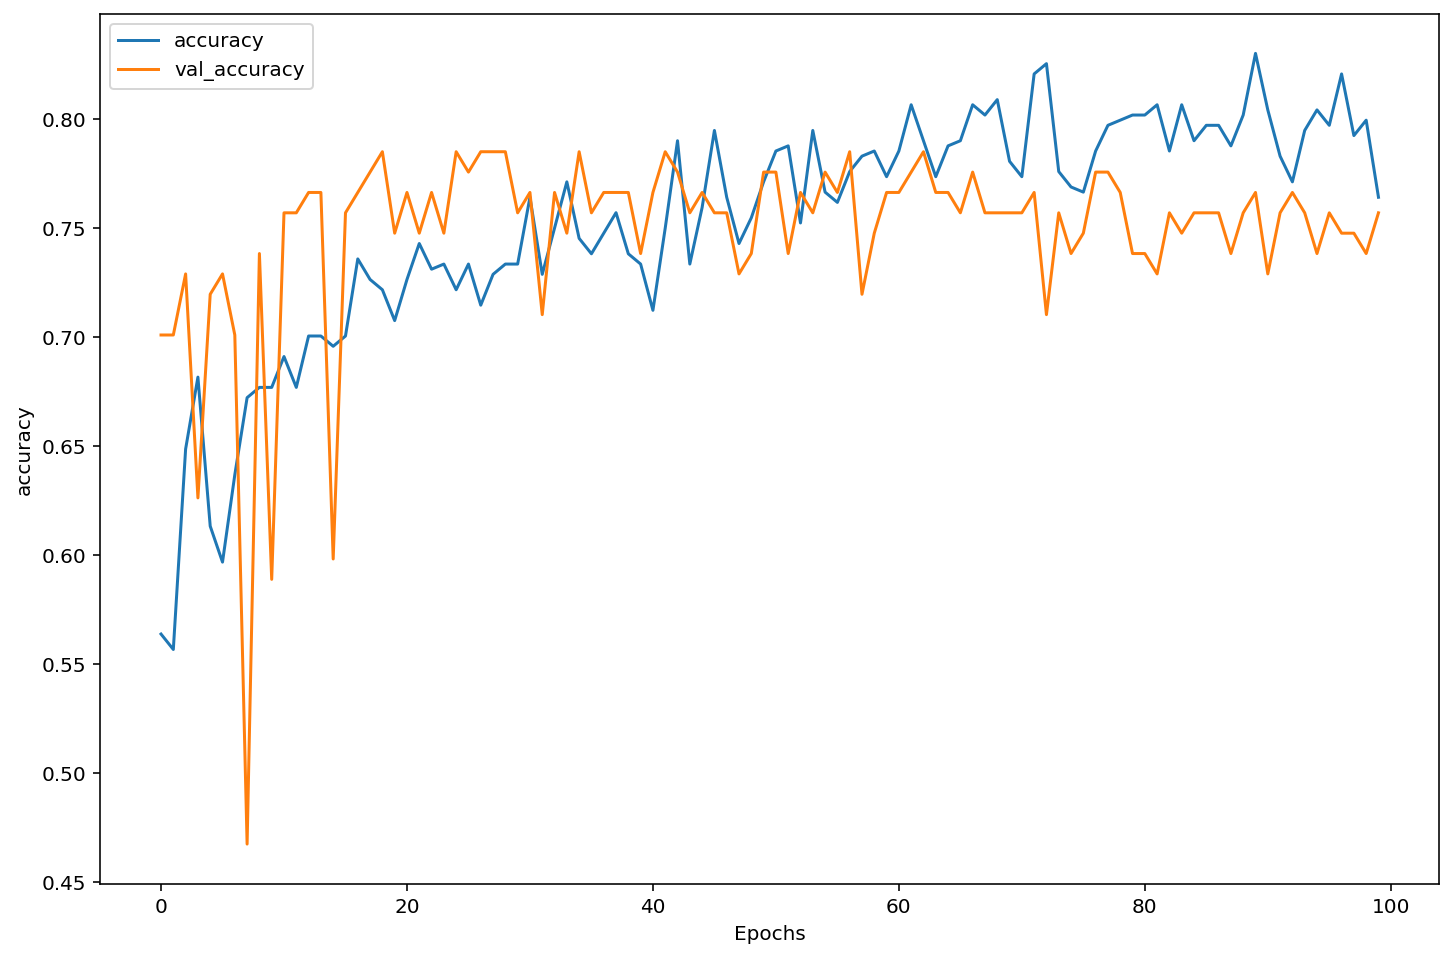

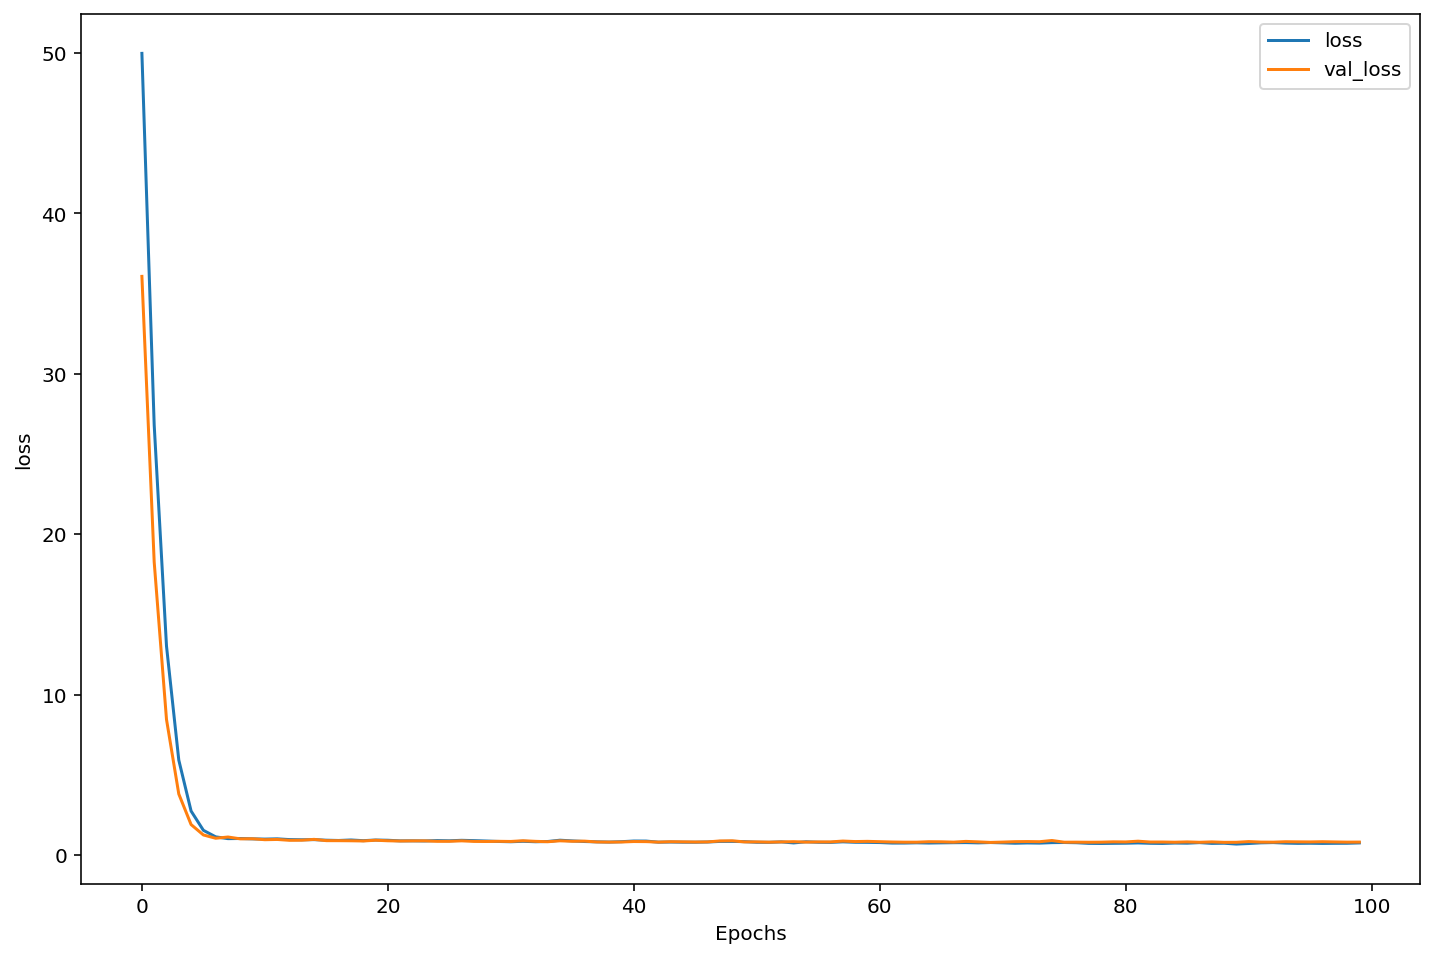

In [0]:
#plot loss and accuracy 
f1 = plt.figure()
plot_graphs(f1,history, "accuracy")
f2 = plt.figure()
plot_graphs(f2,history, "loss")

# Evaluate Model

In [0]:
loss, acc = model.evaluate(X_test,  y_test, verbose=2)

print("Accuracy", acc)
print("Loss", loss)

5/5 - 0s - loss: 0.7447 - accuracy: 0.8045
Accuracy 0.8045112490653992
Loss 0.7446586489677429


# Confusion Metrix

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

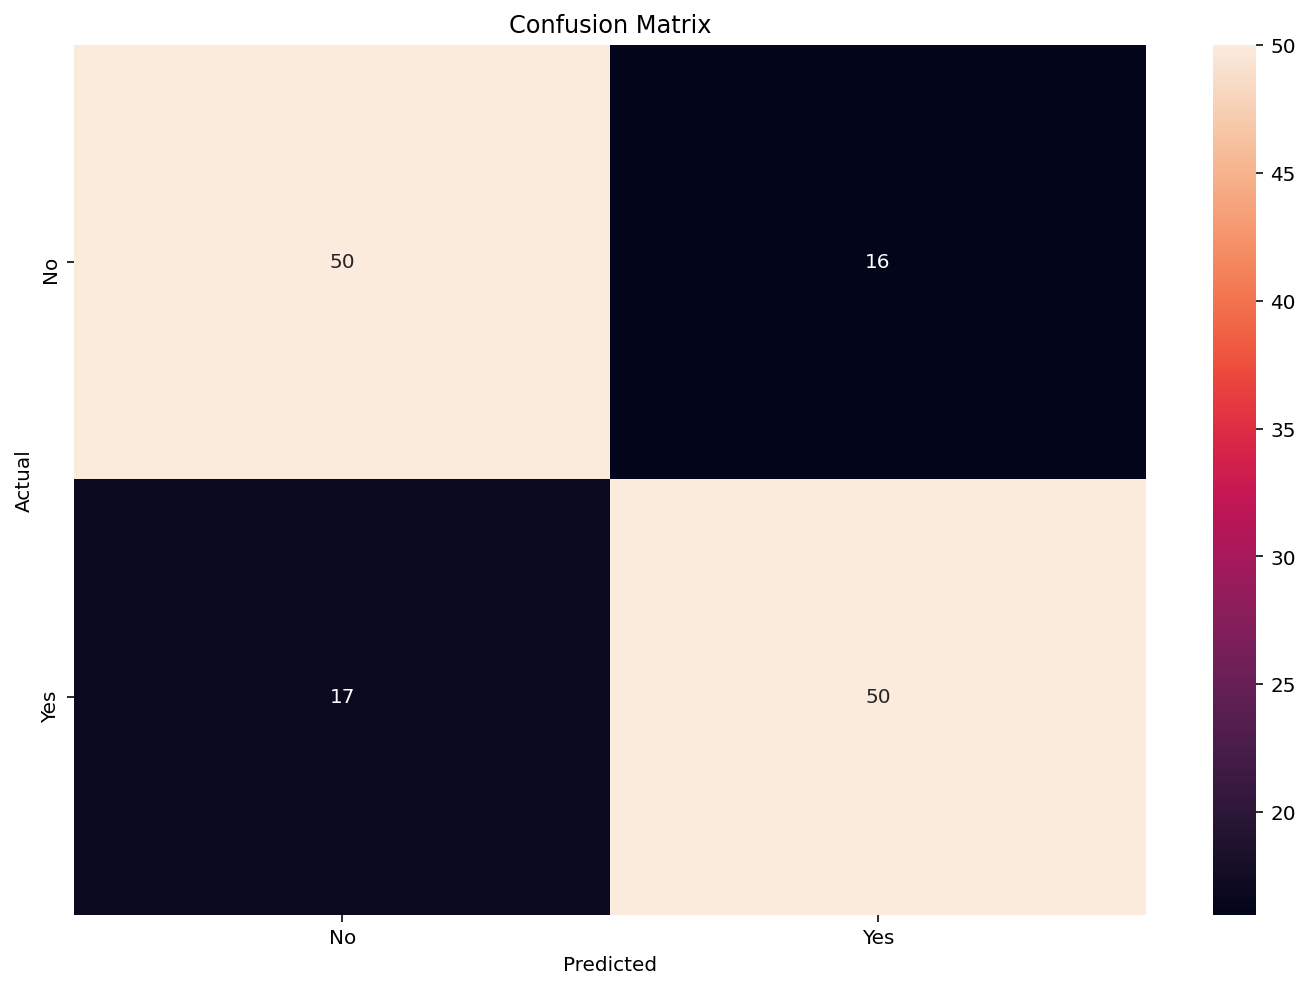

In [0]:
y_pred = model.predict(X_test)
y_pred = (y_pred>0.60)

cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

# Save model

In [0]:
# fileName = 'customer_loan.pkl'
# joblib.dump(model, fileName)
file = 'customer_loan.h5'
model.save(file)